# Working with Cultural Heritage APIs and Semantic Image Search

A complete workshop on digital humanities data collection and analysis using the Europeana API and CLIP.

| Section | Topic |
|---------|-------|
| **1** | Europeana API — browse 50M+ cultural heritage items by country, institution, and keyword |
| **2** | Download a collection — bulk download images from a museum |
| **3** | Semantic text search with CLIP — find artworks using natural language |
| **4** | Image similarity search — find artworks visually similar to a query image |

## Install & Imports

Run the install cell if you are in **Google Colab** or if packages are missing.

In [51]:
# Uncomment and run in Google Colab (torch is already installed there, only CLIP is needed)
# !pip install -q requests Pillow numpy ipywidgets
# !pip install -q git+https://github.com/openai/CLIP.git

In [52]:
import io
import json
import time
from pathlib import Path
from collections import Counter

import numpy as np
import requests
from PIL import Image as PILImage
from IPython.display import display, Image, HTML
import ipywidgets as widgets

try:
    import torch
    import clip
    CLIP_AVAILABLE = True
    print('✓ CLIP loaded successfully!')
except ImportError:
    CLIP_AVAILABLE = False
    print('⚠️ CLIP not available — install it first (see install cell above)')

if CLIP_AVAILABLE:
    if torch.cuda.is_available():
        DEVICE = 'cuda'
        print(f'✓ GPU (CUDA): {torch.cuda.get_device_name(0)}')
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        DEVICE = 'mps'
        print('✓ Apple Silicon GPU (MPS)')
    else:
        DEVICE = 'cpu'
        print('ℹ️ No GPU — using CPU')

✓ CLIP loaded successfully!
✓ GPU (CUDA): NVIDIA RTX A1000 6GB Laptop GPU


In [53]:
# Detect environment and set up paths
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Uncomment to use Google Drive instead:
    # from google.colab import drive
    # drive.mount('/content/drive')
    # PROJECT_ROOT = Path('/content/drive/MyDrive/DH-Workshop')
    PROJECT_ROOT = Path('/content')
    NOTEBOOK_DIR = PROJECT_ROOT
else:
    NOTEBOOK_DIR = Path('.').resolve()
    PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_DIR   = PROJECT_ROOT / 'data'
IMAGES_DIR = DATA_DIR / 'images'
MODELS_DIR = PROJECT_ROOT / 'models' / 'CLIP'

for d in [DATA_DIR, IMAGES_DIR, DATA_DIR / 'embeddings', MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f'Project root : {PROJECT_ROOT}')
print(f'Data dir     : {DATA_DIR}')
print(f'Models dir   : {MODELS_DIR}')

Project root : /home/lauhp/000_PHD/000_003_Code/DH-Workshop
Data dir     : /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data
Models dir   : /home/lauhp/000_PHD/000_003_Code/DH-Workshop/models/CLIP


---

# Section 1: Working with Cultural Heritage APIs (Europeana)

[Europeana](https://www.europeana.eu/) is Europe's digital platform for cultural heritage:
- **50+ million** digitized items from European museums, galleries, libraries and archives
- **3,000+** contributing institutions across Europe
- Collections: artworks, books, music, videos, photographs, manuscripts
- Open data under various Creative Commons licenses

## What is an API?

**API** stands for **Application Programming Interface**. It:
- Takes your **request** ("give me all paintings by Rembrandt")
- Sends it to a **server** (the database)
- Returns a **response** (the data you asked for)

### Why APIs matter for Digital Humanities

| Benefit | Description |
|---------|-------------|
| **Scale** | Download thousands of records automatically instead of clicking through web pages |
| **Structure** | Data comes in machine-readable formats (JSON, XML) ready for analysis |
| **Reproducibility** | Your code documents exactly how you obtained your data |
| **Integration** | Combine data from multiple institutions |

### Common Data Formats

| Format | Description | Example |
|--------|-------------|---------|
| **JSON** | JavaScript Object Notation — human-readable, widely used | `{"name": "Mona Lisa", "year": 1503}` |
| **XML** | eXtensible Markup Language | `<artwork><name>Mona Lisa</name></artwork>` |
| **CSV** | Comma-Separated Values — spreadsheet-like | `name,year\nMona Lisa,1503` |

### How an API Works

![alt text](../misc/assets/img/api.png)

> **Key idea:** You never talk to the database directly — the API is a controlled gateway that handles authentication, rate limiting, and formats the data for you.

## Understanding the Europeana API

### Key Search Parameters

| Parameter | Description | Example |
|-----------|-------------|---------|
| `query` | Search term | `Rembrandt`, `painting`, `*` (all) |
| `qf` | Query filter | `TYPE:IMAGE`, `COUNTRY:Netherlands` |
| `theme` | Thematic collection | `art`, `fashion`, `photography`, `music` |
| `reusability` | License filter | `open`, `restricted`, `permission` |
| `rows` | Results per page (max 100) | `12` (default), `100` |
| `profile` | Detail level | `standard`, `rich`, `facets` |

### Available Themes

| Theme | Description |
|-------|-------------|
| `art` | Paintings, sculptures, and visual art |
| `photography` | Historical and contemporary photographs |
| `fashion` | Clothing, accessories, and fashion design |
| `music` | Musical scores, recordings, and instruments |
| `newspapers` | Historical newspapers and periodicals |
| `nature` | Natural history specimens and illustrations |
| `ww1` | World War I collections |
| `archaeology` | Archaeological artifacts and sites |

### What is a Facet?

A **facet** is a category used to filter and aggregate search results — like a filter dimension in a search interface:
- `COUNTRY` — how many results per country
- `DATA_PROVIDER` — counts by institution/museum
- `TYPE` — counts by media type (image, video, text, etc.)
- `dc_creator` — counts by creator/artist

## API Key

Europeana requires a free API key:
1. Visit: https://pro.europeana.eu/page/get-api
2. Register and request a key
3. Save it to `notebooks/api-key-europeana.txt`

The demo key below works for testing (limited to 999 requests/day).

In [54]:
API_KEY = 'api2demo'  # demo key — get your own at https://pro.europeana.eu/page/get-api

key_locations = [
    NOTEBOOK_DIR / 'api-key-europeana.txt',
    PROJECT_ROOT / 'misc' / 'api-key-europeana.txt',
    PROJECT_ROOT / 'api-key-europeana.txt',
]

for key_file in key_locations:
    if key_file.exists():
        custom = key_file.read_text().strip()
        if custom and custom != 'api2demo':
            API_KEY = custom
            print(f'✓ API key loaded from {key_file}')
            break
else:
    print('ℹ️ Using demo API key (999 requests/day)')
    print('  Get your own key: https://pro.europeana.eu/page/get-api')

BASE_URL = 'https://api.europeana.eu/record/v2'
print(f'API endpoint: {BASE_URL}')

ℹ️ Using demo API key (999 requests/day)
  Get your own key: https://pro.europeana.eu/page/get-api
API endpoint: https://api.europeana.eu/record/v2


## Exploring the Europeana Collection

Let's start by discovering what countries and institutions are available in Europeana using **facets**.

In [55]:
def get_facet_values(facet_name, query='*', qf=None, max_values=50, theme=None):
    """
    Query the Europeana API to get available values for a facet.

    Parameters:
        facet_name: The facet to query (e.g., 'COUNTRY', 'DATA_PROVIDER', 'proxy_dc_creator')
        query:      Search query to filter results (default: '*' for all)
        qf:         Optional query filters as list
        max_values: Maximum number of facet values to return
        theme:      Optional thematic collection filter

    Returns:
        List of (value, count) tuples
    """
    params = {
        'wskey': API_KEY,
        'query': query,
        'rows': 0,
        'profile': 'facets',
        'facet': facet_name,
        f'f.{facet_name}.facet.limit': max_values,
    }
    if qf:
        params['qf'] = qf
    if theme:
        params['theme'] = theme

    try:
        resp = requests.get(f'{BASE_URL}/search.json', params=params, timeout=30)
        resp.raise_for_status()
        for facet in resp.json().get('facets', []):
            if facet.get('name') == facet_name:
                return [(f['label'], f['count']) for f in facet.get('fields', [])]
        return []
    except requests.exceptions.RequestException as e:
        print(f'❌ Error: {e}')
        return []

### Countries

In [56]:
print('Available COUNTRIES in Europeana:')
print('=' * 60)
countries = get_facet_values('COUNTRY', max_values=50)
country_counts = {c: n for c, n in countries}

for country, count in countries:
    print(f'  {country:<30} ({count:,} items)')

print(f'\nTotal countries: {len(countries)}')

Available COUNTRIES in Europeana:
  Netherlands                    (8,845,226 items)
  Germany                        (7,757,624 items)
  Spain                          (6,416,456 items)
  Sweden                         (6,083,438 items)
  United Kingdom                 (5,669,073 items)
  France                         (4,754,602 items)
  Poland                         (3,774,673 items)
  Norway                         (3,682,589 items)
  Belgium                        (2,674,224 items)
  Austria                        (2,147,988 items)
  Italy                          (1,844,306 items)
  Czech Republic                 (1,657,322 items)
  Denmark                        (1,520,041 items)
  Finland                        (1,302,588 items)
  Hungary                        (988,951 items)
  Estonia                        (894,417 items)
  Lithuania                      (832,178 items)
  Greece                         (793,779 items)
  Romania                        (529,539 items)
  Slove

### Institutions

The `DATA_PROVIDER` facet shows which institutions contributed content. Change `COUNTRY_FILTER` to explore a specific country.

In [57]:
# ============================================================
# Change to any country from the list above
# ============================================================
COUNTRY_FILTER = 'Sweden'
# ============================================================

print(f'Top institutions in {COUNTRY_FILTER}:')
print('=' * 60)
providers = get_facet_values('DATA_PROVIDER', query=COUNTRY_FILTER, max_values=25)

for i, (provider, count) in enumerate(providers, 1):
    name = provider[:55] + '...' if len(provider) > 55 else provider
    print(f'  {i:>2}. {name:<58} ({count:,} items)')

Top institutions in Sweden:
   1. Swedish National Heritage Board                            (1,235,208 items)
   2. Nordic Museum Foundation                                   (173,465 items)
   3. Jamtli                                                     (146,434 items)
   4. Malmö Museum                                               (116,271 items)
   5. Kulturen                                                   (95,494 items)
   6. Sörmland Museum                                            (91,216 items)
   7. Skelleftea museum                                          (63,769 items)
   8. Army Museum                                                (55,567 items)
   9. Museum of Gothenburg                                       (46,946 items)
  10. Blekinge Museum                                            (43,279 items)
  11. Swedish History Museum                                     (39,206 items)
  12. Upplands Museum                                            (30,571 items)
  13. 

### Media Types

In [58]:
print('Media types in Europeana:')
print('=' * 60)
for t, count in get_facet_values('TYPE', max_values=10):
    print(f'  {t:<30} ({count:,} items)')

Media types in Europeana:
  IMAGE                          (36,808,457 items)
  TEXT                           (26,524,360 items)
  SOUND                          (1,250,913 items)
  VIDEO                          (434,032 items)
  3D                             (10,444 items)


## Searching for Artworks

The `search_europeana` function is the main interface to the API. Helper functions extract metadata fields from individual result items.

In [59]:
def search_europeana(query='*', rows=12, reusability='open', qf=None,
                     profile='rich', cursor=None, theme=None):
    """
    Search the Europeana collection.

    Parameters:
        query:       Search term (default: '*' for all)
        rows:        Number of results to return (max 100)
        reusability: License filter ('open', 'restricted', 'permission', or None)
        qf:          Additional query filters as list (e.g. ['TYPE:IMAGE', 'COUNTRY:Netherlands'])
        profile:     'standard', 'rich', or 'facets' for more metadata
        cursor:      Cursor for pagination (enables retrieving more than 100 results)
        theme:       Thematic collection (e.g. 'art', 'photography', 'nature')

    Returns:
        Dictionary with search results
    """
    params = {
        'wskey': API_KEY,
        'query': query,
        'rows': min(rows, 100),
        'profile': profile,
    }
    if reusability:
        params['reusability'] = reusability
    if qf:
        params['qf'] = qf
    if cursor:
        params['cursor'] = cursor
    if theme:
        params['theme'] = theme

    try:
        resp = requests.get(f'{BASE_URL}/search.json', params=params, timeout=30)
        resp.raise_for_status()
        return resp.json()
    except requests.exceptions.RequestException as e:
        print(f'❌ Error: {e}')
        return None


def get_item_title(item):
    """Extract title from a result item."""
    if 'title' in item and item['title']:
        return item['title'][0] if isinstance(item['title'], list) else item['title']
    if 'dcTitleLangAware' in item:
        for lang in ['en', 'nl', 'de', 'fr', 'sv', 'def']:
            if lang in item['dcTitleLangAware']:
                return item['dcTitleLangAware'][lang][0]
    return 'Untitled'


def get_item_creator(item):
    """Extract creator/artist from a result item."""
    if 'dcCreator' in item and item['dcCreator']:
        return item['dcCreator'][0] if isinstance(item['dcCreator'], list) else item['dcCreator']
    return 'Unknown'


def get_item_year(item):
    """Extract year from a result item."""
    if 'year' in item and item['year']:
        return item['year'][0] if isinstance(item['year'], list) else item['year']
    return 'n.d.'


def get_item_preview(item):
    """Extract preview thumbnail URL from a result item."""
    if 'edmPreview' in item and item['edmPreview']:
        return item['edmPreview'][0] if isinstance(item['edmPreview'], list) else item['edmPreview']
    return None


def sanitize_filename(name):
    """Remove problematic characters from filenames."""
    if not name:
        return 'unknown'
    return ''.join(c for c in name if c.isalnum() or c in ' ._-').strip()[:80]


print('✓ Functions ready')

✓ Functions ready


### Exercise: Search by Keyword

Change `SEARCH_KEYWORD` and run the cell to explore Europeana's art collection.

In [60]:
# ============================================================
# EXERCISE: Change the keyword and run this cell!
# Try: "sunset", "portrait", "horse", "river", "spaceship"
# ============================================================
SEARCH_KEYWORD = 'river'
# ============================================================

print(f"Searching for '{SEARCH_KEYWORD}' in the Art collection...")
print('=' * 60)

results = search_europeana(
    query=SEARCH_KEYWORD,
    rows=100,
    qf=['TYPE:IMAGE'],
    theme='art',
    reusability='open'
)

if results and results.get('success'):
    items = results.get('items', [])
    print(f"✓ Found {results['totalResults']:,} art images matching '{SEARCH_KEYWORD}'")
    print(f'  Showing first {len(items)} results\n')
    print('🖼️  Preview:\n')
    for item in items[:3]:
        title   = get_item_title(item)
        creator = get_item_creator(item)
        year    = get_item_year(item)
        preview = get_item_preview(item)
        print(f'{title}  —  {creator} ({year})')
        if preview:
            display(Image(url=preview, width=300))
else:
    print('❌ Search failed or no results')
    items = []

Searching for 'river' in the Art collection...
✓ Found 4,158 art images matching 'river'
  Showing first 100 results

🖼️  Preview:

Hunter River (?)  —  Josef Selleny (Künstler_in) (1858)


Chinese river boat Min River.  —  http://data.europeana.eu/agent/168352 (n.d.)


River  —  Unknown (1848)


## IIIF — International Image Interoperability Framework

**IIIF** (*"triple-eye-eff"*) is a family of open standards that lets cultural heritage institutions share their digitised collections in a consistent, interoperable way.

Without IIIF, every museum builds its own image viewer — making it impossible to combine images across institutions. IIIF solves this with a **common language**: any IIIF-compatible viewer can display content from any IIIF-compatible server.


![alt text](../misc/assets/img/iif.svg)



### The Four Key APIs

| API | Purpose |
|-----|---------|
| **Presentation API** | Describes what to show and in what order — the manifest, canvases, sequences |
| **Image API** | Delivers image pixels on demand: crop, resize, rotate any region |
| **Search API** | Full-text search within the content of a manifest |
| **Authentication API** | Controls access to restricted or rights-managed content |

### IIIF Image API URL Structure

```
{service_url}/{region}/{size}/{rotation}/{quality}.{format}
```

| Parameter | Examples |
|-----------|---------|
| **region** | `full` · `square` · `x,y,w,h` · `pct:x,y,w,h` |
| **size** | `max` · `500,` (width) · `,300` (height) · `pct:50` |
| **rotation** | `0` · `90` · `180` · `!0` (mirror) |
| **quality** | `default` · `color` · `gray` · `bitonal` |
| **format** | `jpg` · `png` · `webp` · `tif` |

In [62]:
def get_iiif_manifest_url(item):
    """
    Construct the Europeana IIIF manifest URL for an item.
    Pattern: https://iiif.europeana.eu/presentation/{dataset}/{local_id}/manifest
    """
    item_id = item.get('id')
    if not item_id:
        return None
    parts = item_id.strip('/').split('/')
    if len(parts) >= 2:
        return f'https://iiif.europeana.eu/presentation/{parts[0]}/{parts[1]}/manifest'
    return None


# Show IIIF manifest URLs for the search results above
if items:
    print('🔗 IIIF Manifest URLs for your search results:')
    print('=' * 60)
    for item in items[:5]:
        title = get_item_title(item)[:50]
        url   = get_iiif_manifest_url(item)
        if url:
            print(f'\n{title}')
            print(f'  {url}')
else:
    print('ℹ️ Run the search cell above first.')

🔗 IIIF Manifest URLs for your search results:

Hunter River (?)
  https://iiif.europeana.eu/presentation/15508/28966/manifest

Chinese river boat Min River.
  https://iiif.europeana.eu/presentation/9200579/rgsdsm4r/manifest

River
  https://iiif.europeana.eu/presentation/9200579/ytwx83ue/manifest

Jordan River.
  https://iiif.europeana.eu/presentation/318/marc_nli_004031769/manifest

Tana River
  https://iiif.europeana.eu/presentation/2021012/_C713D093F8CEA6EF5BAC4AA156944622/manifest


---

# Section 2: Downloading a Collection

In this section we download thumbnail images from a specific museum for use in Sections 3 and 4.

## Swedish Institutions Reference

Run the Institutions cell in Section 1 with `COUNTRY_FILTER = 'Sweden'` to see the full list. Here are the top 25:

| # | Institution | Items |
|---|-------------|-------|
| 1 | Swedish National Heritage Board | 1,414,618 |
| 2 | Nordic Museum Foundation | 351,553 |
| 3 | Malmö Museum | 288,308 |
| 4 | Museum of Ethnography | 271,525 |
| 5 | Museum of World Culture | 230,176 |
| 6 | Upplands Museum | 218,928 |
| 7 | Jamtli | 173,095 |
| 8 | Museum of Gothenburg | 171,960 |
| 9 | Swedish National Museum of Science and Technology | 150,809 |
| 10 | Swedish Railway Museum | 145,093 |
| 11 | Naval Museum | 143,623 |
| 12 | Bohuslän Museum | 140,521 |
| 13 | Gävleborg County Museum | 133,207 |
| 14 | Kulturen | 130,732 |
| 15 | Örebro County Museum | 125,272 |
| 16 | Västergötlands Museum | 117,479 |
| 17 | Army Museum | 114,513 |
| 18 | Sörmland Museum | 107,177 |
| 19 | National Maritime Museum | 103,829 |
| 20 | Vänersborgs museum | 103,249 |
| 21 | Museum of Far Eastern Antiquities | 74,426 |
| 22 | Uppsala University | 74,233 |
| 23 | Hälsinglands Museum | 73,678 |
| 24 | Swedish Centre for Architecture and Design | 67,581 |
| 25 | Army Museum | 114,513 |

## Configure Your Download

Set `COLLECTION_NAME` to the exact `DATA_PROVIDER` name from Europeana (see table above or run the Institutions cell). The folder name and embedding paths are auto-generated from your settings.

In [65]:
# ============================================================
# CONFIGURATION — adjust to choose your collection
# ============================================================
COLLECTION_NAME = 'Jamtli'  # exact DATA_PROVIDER name from Europeana
THEME           = 'art'                   # 'art', 'photography', etc. — or None for all types
SEARCH_KEYWORD  = None                    # extra keyword filter — or None for all
MAX_DOWNLOAD    = 200                     # number of images to download
DO_DOWNLOAD     = True                    # set False to skip downloading

# CLIP model (used in Sections 3 & 4)
MODEL_NAME = 'ViT-B/32'  # options: 'RN50', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14'
# ============================================================

# Auto-generate folder name and file paths from the config above
_parts = [COLLECTION_NAME.replace(' ', '_')]
if THEME:          _parts.append(THEME)
if SEARCH_KEYWORD: _parts.append(SEARCH_KEYWORD)
_folder_name = '_'.join(_parts)

COLLECTION_IMAGES_DIR      = DATA_DIR / 'images'     / _folder_name
COLLECTION_EMBEDDINGS_FILE = DATA_DIR / 'embeddings' / _folder_name / f'{_folder_name}_clip_embeddings.npz'

COLLECTION_IMAGES_DIR.mkdir(parents=True, exist_ok=True)
COLLECTION_EMBEDDINGS_FILE.parent.mkdir(parents=True, exist_ok=True)

print(f'Collection  : {COLLECTION_NAME}')
print(f'Theme       : {THEME or "(all)"}')
print(f'Keyword     : {SEARCH_KEYWORD or "(all)"}')
print(f'Folder      : {_folder_name}/')
print(f'Images    → {COLLECTION_IMAGES_DIR}')
print(f'Embeddings→ {COLLECTION_EMBEDDINGS_FILE}')

Collection  : Jamtli
Theme       : art
Keyword     : (all)
Folder      : Jamtli_art/
Images    → /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/images/Jamtli_art
Embeddings→ /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/embeddings/Jamtli_art/Jamtli_art_clip_embeddings.npz


In [66]:
def download_collection(
    collection_name,
    theme=None,
    keyword=None,
    max_images=200,
    output_dir=None,
    delay=0.3
):
    """
    Download thumbnail images from a specific Europeana institution.

    Parameters:
        collection_name : DATA_PROVIDER name in Europeana (e.g. 'Museum of Gothenburg')
        theme           : Thematic collection filter (e.g. 'art'), or None for all
        keyword         : Optional keyword to narrow results, or None
        max_images      : Maximum number of images to download
        output_dir      : Path to save images (auto-generated from params if None)
        delay           : Seconds to wait between requests (be polite to the server)

    Returns:
        List of Path objects for all images in the output directory
    """
    if output_dir is None:
        parts = [collection_name.replace(' ', '_')]
        if theme:   parts.append(theme)
        if keyword: parts.append(keyword)
        output_dir = DATA_DIR / 'images' / '_'.join(parts)

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    qf    = [f'DATA_PROVIDER:"{collection_name}"', 'TYPE:IMAGE']
    query = keyword or '*'

    print(f'📥 {collection_name}')
    if theme:   print(f'   theme   = {theme}')
    if keyword: print(f'   keyword = {keyword}')
    print(f'   max     = {max_images}')
    print(f'   folder  → {output_dir.name}/')
    print('=' * 60)

    check = search_europeana(query=query, rows=1, qf=qf, theme=theme, reusability='open')
    if not check or not check.get('success'):
        print('❌ Could not reach API')
        return []

    print(f"✓ {check['totalResults']:,} images available\n")

    cursor    = '*'
    processed = 0
    new_dl    = 0

    while processed < max_images:
        batch  = min(100, max_images - processed)
        result = search_europeana(
            query=query, rows=batch, qf=qf, theme=theme,
            reusability='open', cursor=cursor
        )
        if not result or not result.get('items'):
            break

        for item in result['items']:
            if processed >= max_images:
                break

            preview_url = get_item_preview(item)
            if not preview_url:
                processed += 1
                continue

            item_id    = item.get('id', 'unknown').replace('/', '_')
            safe_title = sanitize_filename(get_item_title(item))[:40]
            filepath   = output_dir / f'{item_id}_{safe_title}.jpg'

            if filepath.exists() and filepath.stat().st_size > 0:
                processed += 1
                continue

            try:
                resp = requests.get(preview_url, timeout=20)
                resp.raise_for_status()
                filepath.write_bytes(resp.content)
                new_dl += 1
                if new_dl % 50 == 0:
                    print(f'  {new_dl} images downloaded...')
                time.sleep(delay)
            except Exception:
                pass

            processed += 1

        cursor = result.get('nextCursor')
        if not cursor:
            break

    all_files = list(output_dir.glob('*.jpg'))
    existing  = len(all_files) - new_dl
    print(f'\n✓ Done: {new_dl} new  +  {existing} already existed  =  {len(all_files)} total')
    print(f'   {output_dir}')
    return all_files


print('✓ download_collection ready')

✓ download_collection ready


## Run the Download

In [67]:
if DO_DOWNLOAD:
    downloaded_files = download_collection(
        collection_name = COLLECTION_NAME,
        theme           = THEME,
        keyword         = SEARCH_KEYWORD,
        max_images      = MAX_DOWNLOAD,
        output_dir      = COLLECTION_IMAGES_DIR,
    )
else:
    print('ℹ️ Download skipped — set DO_DOWNLOAD = True to download.')
    existing = list(COLLECTION_IMAGES_DIR.glob('*.jpg'))
    if existing:
        print(f'   Found {len(existing)} existing images in {COLLECTION_IMAGES_DIR.name}/')
    else:
        print(f'   No images yet in {COLLECTION_IMAGES_DIR.name}/')

📥 Jamtli
   theme   = art
   max     = 200
   folder  → Jamtli_art/
✓ 3,835 images available

  50 images downloaded...
  100 images downloaded...
  150 images downloaded...
  200 images downloaded...

✓ Done: 200 new  +  0 already existed  =  200 total
   /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/images/Jamtli_art


---

# Section 3: Semantic Text Search with CLIP

## What is CLIP?

**CLIP** (Contrastive Language–Image Pre-Training) is a neural network by OpenAI trained on **400 million image–text pairs** from the internet. It learns to match images with their captions.


![OpenAI — CLIP: Connecting Text and Images](../misc/assets/img/clip.svg)

*Source: [OpenAI — CLIP: Connecting Text and Images](https://openai.com/index/clip/)*

CLIP encodes both images and text into the same **512-dimensional space**. Similar concepts end up close together:

```
"a river landscape"    ←→  🖼️  painting of a river
"portrait of a woman" ←→  🖼️  portrait painting
"boats at sea"         ←→  🖼️  seascape with ships
```

This means you can search an image collection **using plain English** — no manual tagging needed.

![CLIP pipeline](../misc/assets/img/clip-pipeline.png)


## What is a CLIP embedding?

#### the content of a clip embedding visualized...
![CLIP pipeline](../misc/assets/img/embedding.png)

## Load the CLIP Model

The model weights (~350 MB for ViT-B/32) are downloaded on the first run and cached in `models/CLIP/` — subsequent runs load instantly from disk.

| Model | Dimensions | Speed | Quality |
|-------|-----------|-------|---------|
| `RN50` | 1024 | Fast | Good |
| `ViT-B/32` | 512 | Fast | Good ✓ |
| `ViT-B/16` | 512 | Medium | Better |
| `ViT-L/14` | 768 | Slow | Best |

In [68]:
if CLIP_AVAILABLE:
    print(f"Loading CLIP model '{MODEL_NAME}'...")
    print(f'  Cache: {MODELS_DIR}')
    model, preprocess = clip.load(MODEL_NAME, device=DEVICE, download_root=str(MODELS_DIR))
    model.eval()
    print(f'✓ Model ready on {DEVICE}')
else:
    print('❌ CLIP not available — install it first (see install cell at the top)')

Loading CLIP model 'ViT-B/32'...
  Cache: /home/lauhp/000_PHD/000_003_Code/DH-Workshop/models/CLIP
✓ Model ready on cuda


## Compute Image Embeddings

An **embedding** is a 512-number vector encoding the meaning of an image. We process all downloaded images in batches, normalize each embedding to unit length, and save everything to a `.npz` file — so we never have to recompute.

```
Image → resize & normalize → CLIP image encoder → 512-dim vector → save to .npz
```

In [69]:
BATCH_SIZE = 32  # reduce to 8 if you run out of GPU memory

if not CLIP_AVAILABLE:
    print('❌ CLIP not available')
elif COLLECTION_EMBEDDINGS_FILE.exists():
    print('✓ Embeddings already exist — skipping computation.')
    print(f'  Delete {COLLECTION_EMBEDDINGS_FILE.name} and re-run to recompute.')
else:
    image_files = sorted(
        f for f in COLLECTION_IMAGES_DIR.glob('*')
        if f.suffix.lower() in ('.jpg', '.jpeg', '.png', '.webp')
    )

    if not image_files:
        print(f'⚠️ No images found in {COLLECTION_IMAGES_DIR}')
        print('   Run Section 2 first to download images.')
    else:
        print(f'Computing embeddings for {len(image_files)} images...')
        print(f'  Model: {MODEL_NAME}  |  Device: {DEVICE}  |  Batch: {BATCH_SIZE}\n')

        all_embeddings, all_filenames, failed = [], [], []
        t0 = time.time()

        for i in range(0, len(image_files), BATCH_SIZE):
            batch_files   = image_files[i : i + BATCH_SIZE]
            batch_tensors, batch_names = [], []

            for img_path in batch_files:
                try:
                    img = PILImage.open(img_path).convert('RGB')
                    batch_tensors.append(preprocess(img))
                    batch_names.append(img_path.name)
                except Exception as e:
                    failed.append((img_path.name, str(e)))

            if batch_tensors:
                with torch.no_grad():
                    batch = torch.stack(batch_tensors).to(DEVICE)
                    emb   = model.encode_image(batch).float()
                    emb   = emb / emb.norm(dim=-1, keepdim=True)
                all_embeddings.append(emb.cpu().numpy())
                all_filenames.extend(batch_names)

            done = min(i + BATCH_SIZE, len(image_files))
            if done % (BATCH_SIZE * 5) == 0 or done == len(image_files):
                elapsed = time.time() - t0
                print(f'  {done:>5}/{len(image_files)}  ({done/elapsed:.0f} img/s)')

        embeddings_array = np.vstack(all_embeddings)
        np.savez_compressed(
            COLLECTION_EMBEDDINGS_FILE,
            embeddings=embeddings_array,
            filenames=np.array(all_filenames, dtype=object),
            model_name=MODEL_NAME,
            embedding_dim=embeddings_array.shape[1],
        )

        elapsed = time.time() - t0
        if failed:
            print(f'  ⚠️ {len(failed)} images failed to process')
        print(f'\n✓ Saved {len(all_filenames)} embeddings in {elapsed:.0f}s')
        print(f'  Shape: {embeddings_array.shape}')
        print(f'  File:  {COLLECTION_EMBEDDINGS_FILE}')

Computing embeddings for 200 images...
  Model: ViT-B/32  |  Device: cuda  |  Batch: 32

    160/200  (159 img/s)
    200/200  (163 img/s)

✓ Saved 200 embeddings in 1s
  Shape: (200, 512)
  File:  /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/embeddings/Jamtli_art/Jamtli_art_clip_embeddings.npz


In [70]:
# Load embeddings from disk
if COLLECTION_EMBEDDINGS_FILE.exists():
    data = np.load(COLLECTION_EMBEDDINGS_FILE, allow_pickle=True)
    image_embeddings = data['embeddings']
    image_filenames  = data['filenames']
    saved_model      = str(data.get('model_name', 'unknown'))

    print(f'✓ Loaded {len(image_filenames)} embeddings')
    print(f'  Shape: {image_embeddings.shape}  |  Model: {saved_model}')

    if CLIP_AVAILABLE:
        image_embeddings = torch.tensor(image_embeddings, dtype=torch.float32).to(DEVICE)
else:
    image_embeddings = None
    image_filenames  = None
    print(f'⚠️ Embeddings not found: {COLLECTION_EMBEDDINGS_FILE}')
    print('   Run the compute cell above first.')

✓ Loaded 200 embeddings
  Shape: (200, 512)  |  Model: ViT-B/32


## Search with Natural Language

### How It Works

1. **Encode the query** — CLIP's text encoder turns your sentence into a 512-dim vector
2. **Dot product** — compare it against every image vector
3. **Rank by similarity** — images pointing in the same direction score highest

Because all embeddings are normalized to length 1, the dot product equals **cosine similarity**:

| Score | Meaning |
|-------|---------|
| **≈ 1.0** | Very similar |
| **≈ 0.0** | Unrelated |
| **≈ −1.0** | Opposite |

### Prompt Ensembling

A single query like `"river"` can be ambiguous. *Prompt ensembling* encodes several phrasings and averages them — the mean vector is more robust:

```python
["river", "a painting of a river", "river landscape", "river in art"]
→  average  →  one combined embedding
```

### Query Tips

| Instead of… | Try… |
|-------------|------|
| `water` | `river flowing through a landscape` |
| `person` | `portrait of an elderly woman` |
| `nature` | `forest with tall pine trees in winter` |

In [71]:
def encode_text(text_query):
    """Convert a text string into a normalised CLIP embedding."""
    with torch.no_grad():
        tokens = clip.tokenize([text_query]).to(DEVICE)
        emb    = model.encode_text(tokens).float()
        emb    = emb / emb.norm(dim=-1, keepdim=True)
    return emb


def encode_text_ensemble(queries):
    """Encode multiple queries and return their mean embedding."""
    with torch.no_grad():
        tokens = clip.tokenize(queries).to(DEVICE)
        embs   = model.encode_text(tokens).float()
        mean   = embs.mean(dim=0, keepdim=True)
        mean   = mean / mean.norm(dim=-1, keepdim=True)
    return mean


def semantic_search(query, top_k=10, use_ensemble=True):
    """
    Search the collection with a natural-language query.

    Parameters:
        query:        Search string
        top_k:        Number of results to return
        use_ensemble: Expand query into multiple phrasings for robustness

    Returns:
        List of (filename, similarity_score) tuples, highest score first
    """
    if image_embeddings is None:
        print('❌ No embeddings loaded — run the load cell above first')
        return []

    if use_ensemble:
        text_emb = encode_text_ensemble([
            query,
            f'a painting of {query}',
            f'an artwork showing {query}',
            f'{query} in art',
        ])
    else:
        text_emb = encode_text(query)

    similarities = (image_embeddings @ text_emb.T).squeeze()
    top_indices  = similarities.argsort(descending=True)[:top_k]

    return [
        (str(image_filenames[i.item()]), similarities[i].item())
        for i in top_indices
    ]


def display_results(results, max_display=5):
    """Display top search results as inline images with similarity scores."""
    shown = 0
    for filename, score in results[:max_display]:
        img_path = COLLECTION_IMAGES_DIR / Path(filename).name
        print(f'\nScore: {score:.4f}  |  {Path(filename).name[:60]}')
        if img_path.exists():
            try:
                img   = PILImage.open(img_path)
                ratio = min(400 / img.width, 400 / img.height)
                if ratio < 1:
                    img = img.resize(
                        (int(img.width * ratio), int(img.height * ratio)),
                        PILImage.Resampling.LANCZOS
                    )
                display(img)
                shown += 1
            except Exception as e:
                print(f'  [Could not display: {e}]')
        else:
            print('  [Image not found locally — run Section 2 first]')

    if shown == 0:
        print('\n⚠️ No images displayed. Make sure Section 2 download has been run.')


print('✓ Search functions ready')

✓ Search functions ready


### Exercise: Search by Natural Language

Change `SEARCH_QUERY` and run the cell. Longer, more descriptive queries usually work better — CLIP was trained on image captions, not single keywords.

🔍 'riverside'
 1. 0.2486  _76_jlm_item_325340_Vy.jpg
 2. 0.2392  _76_jlm_item_330321_Portrait.jpg
 3. 0.2383  _76_jlm_item_327596_Porträtt.jpg
 4. 0.2381  _76_jlm_item_327481_Vy.jpg
 5. 0.2375  _76_jlm_item_330320_Portrait.jpg
 6. 0.2370  _76_jlm_item_330338_Sjöfart.jpg
 7. 0.2361  _76_jlm_item_330323_Porträtt.jpg
 8. 0.2335  _76_jlm_item_196759_Portrait.jpg
 9. 0.2325  _76_jlm_item_327490_Byggnad.jpg
10. 0.2323  _76_jlm_item_330339_Sjöfart.jpg

🖼️  Top results for 'riverside':

Score: 0.2486  |  _76_jlm_item_325340_Vy.jpg


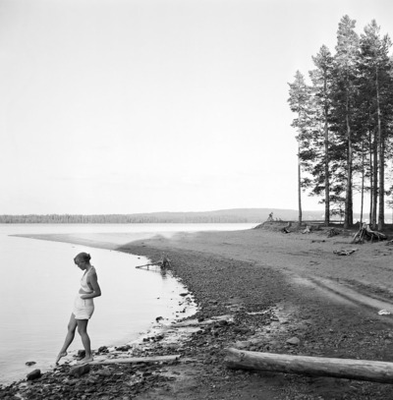


Score: 0.2392  |  _76_jlm_item_330321_Portrait.jpg


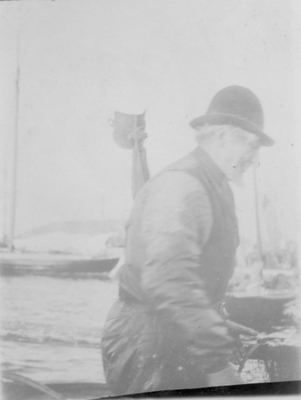


Score: 0.2383  |  _76_jlm_item_327596_Porträtt.jpg


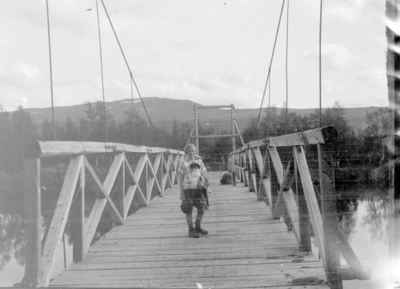


Score: 0.2381  |  _76_jlm_item_327481_Vy.jpg


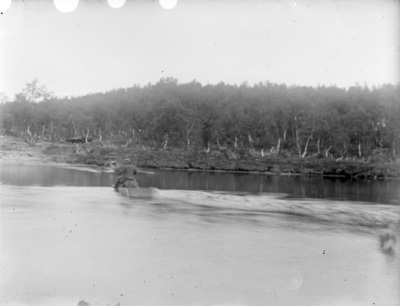


Score: 0.2375  |  _76_jlm_item_330320_Portrait.jpg


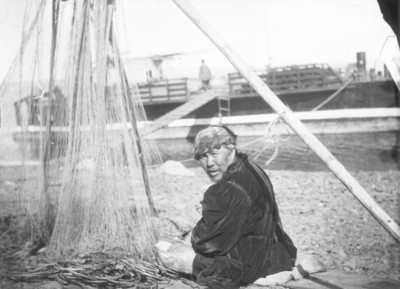

In [72]:
# ============================================================
# EXERCISE: Change the query and run!
# ============================================================
SEARCH_QUERY = 'riverside'
TOP_K        = 10
# ============================================================

if CLIP_AVAILABLE and image_embeddings is not None:
    print(f"🔍 '{SEARCH_QUERY}'")
    print('=' * 50)

    results_text = semantic_search(SEARCH_QUERY, top_k=TOP_K, use_ensemble=True)

    for i, (filename, score) in enumerate(results_text, 1):
        print(f'{i:2}. {score:.4f}  {Path(filename).name[:55]}')

    print(f"\n🖼️  Top results for '{SEARCH_QUERY}':")
    display_results(results_text, max_display=5)
else:
    print('❌ CLIP or embeddings not available')
    results_text = []

In [73]:
def save_search_results(results, query, output_dir=None):
    """Save search results to a JSON file."""
    out_dir  = Path(output_dir or DATA_DIR)
    out_dir.mkdir(parents=True, exist_ok=True)
    safe_q   = ''.join(c for c in query if c.isalnum() or c in ' _-')[:40]
    out_path = out_dir / f"clip_search_{safe_q.replace(' ', '_')}.json"
    with open(out_path, 'w') as f:
        json.dump({
            'query':   query,
            'model':   MODEL_NAME,
            'results': [{'filename': fn, 'similarity': sc} for fn, sc in results]
        }, f, indent=2)
    print(f'✓ Saved {len(results)} results → {out_path}')


if 'results_text' in dir() and results_text:
    save_search_results(results_text, SEARCH_QUERY)

✓ Saved 10 results → /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/clip_search_riverside.json


---

# Section 4: Image Similarity Search

Use an image as the query — find museum artworks visually similar to any photo you provide.

## Text Search vs. Image Search

| | Text Search (Section 3) | Image Search (this section) |
|--|--------------------------|------------------------------|
| **Query** | `"a river landscape"` | 🖼️ any image file |
| **Encoded by** | CLIP text encoder | CLIP image encoder |
| **Finds** | images matching the description | images with similar visual content |
| **Use case** | explore by concept | "find more like this" |

Both use the same embedding space — the query just comes from a different encoder.

## Upload a Query Image

You can use any image as your query — a painting, a photograph, even a smartphone photo. CLIP encodes it into the same 512-dim space and finds the closest matches.

In [74]:
upload = widgets.FileUpload(accept='image/*', multiple=False)
display(upload)
print("Click 'Upload', select an image file, then run the next cell.")

FileUpload(value=(), accept='image/*', description='Upload')

Click 'Upload', select an image file, then run the next cell.


✓ Loaded: laura.jpg  (1920×1279)


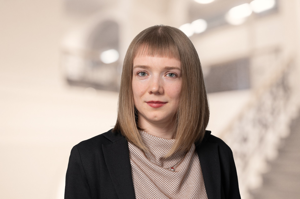

In [76]:
query_image = None

if upload.value:
    file_info   = upload.value[0]          # ipywidgets 8+: tuple of dicts
    img_bytes   = file_info['content']
    name        = file_info['name']
    query_image = PILImage.open(io.BytesIO(img_bytes)).convert('RGB')
    w, h        = query_image.size
    print(f'✓ Loaded: {name}  ({w}×{h})')
    thumb = query_image.resize((300, int(300 * h / w)))
    display(thumb)
else:
    print('No file uploaded yet — upload an image above, then re-run this cell.')

## Find Similar Artworks

In [77]:
def image_similarity_search(query_img, top_k=10, exclude_self=True):
    """
    Find collection images most similar to a query image.

    Parameters:
        query_img:    PIL Image to use as the query
        top_k:        Number of results to return
        exclude_self: Skip near-identical matches (score > 0.9999)

    Returns:
        List of (filename, similarity_score) tuples
    """
    if image_embeddings is None:
        print('❌ No embeddings — run Section 3 first')
        return []

    with torch.no_grad():
        tensor    = preprocess(query_img).unsqueeze(0).to(DEVICE)
        query_emb = model.encode_image(tensor).float()
        query_emb = query_emb / query_emb.norm(dim=-1, keepdim=True)

    sims    = (image_embeddings @ query_emb.T).squeeze()
    results = []
    for idx in sims.argsort(descending=True):
        fname = str(image_filenames[idx.item()])
        score = sims[idx].item()
        if exclude_self and score > 0.9999:
            continue
        results.append((fname, score))
        if len(results) >= top_k:
            break

    return results

🔍 Searching for similar images...

Top 10 most similar images:

 1. 0.5276  _76_jlm_item_312054_Portrait.jpg
 2. 0.5231  _76_jlm_item_318194_Portrait.jpg
 3. 0.5210  _76_jlm_item_327561_Portrait.jpg
 4. 0.5202  _76_jlm_item_312052_Porträtt.jpg
 5. 0.5161  _76_jlm_item_327241_Portrait.jpg
 6. 0.5139  _76_jlm_item_312033_Portrait.jpg
 7. 0.5108  _76_jlm_item_311931_Portrait.jpg
 8. 0.5103  _76_jlm_item_312016_Porträtt.jpg
 9. 0.5101  _76_jlm_item_312030_Porträtt.jpg
10. 0.5100  _76_jlm_item_327556_Interiör.jpg

🖼️  Top results:

Similarity: 0.5276  |  _76_jlm_item_312054_Portrait.jpg


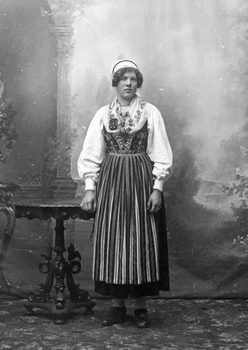


Similarity: 0.5231  |  _76_jlm_item_318194_Portrait.jpg


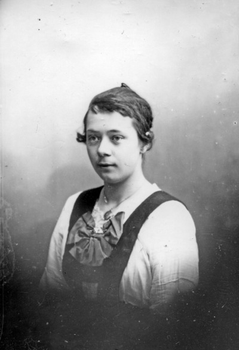


Similarity: 0.5210  |  _76_jlm_item_327561_Portrait.jpg


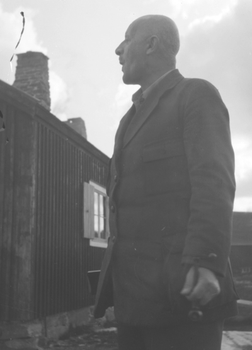


Similarity: 0.5202  |  _76_jlm_item_312052_Porträtt.jpg


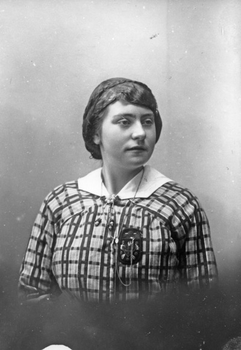


Similarity: 0.5161  |  _76_jlm_item_327241_Portrait.jpg


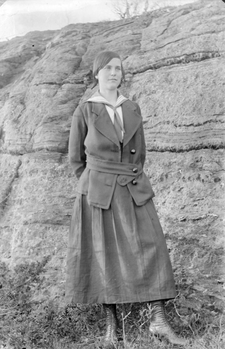

In [78]:
if CLIP_AVAILABLE and image_embeddings is not None and query_image is not None:
    print('🔍 Searching for similar images...')
    similar = image_similarity_search(query_image, top_k=10)

    print(f'\nTop {len(similar)} most similar images:\n')
    for i, (fname, score) in enumerate(similar, 1):
        print(f'{i:2}. {score:.4f}  {Path(fname).name[:60]}')

    print('\n🖼️  Top results:')
    for fname, score in similar[:5]:
        img_path = COLLECTION_IMAGES_DIR / Path(fname).name
        print(f'\nSimilarity: {score:.4f}  |  {Path(fname).name[:60]}')
        if img_path.exists():
            img = PILImage.open(img_path)
            ratio = min(350 / img.width, 350 / img.height)
            if ratio < 1:
                img = img.resize(
                    (int(img.width * ratio), int(img.height * ratio)),
                    PILImage.Resampling.LANCZOS
                )
            display(img)
        else:
            print('  [file not found locally]')
else:
    if query_image is None:
        print('❌ No query image — upload an image in the cell above first.')
    elif not CLIP_AVAILABLE:
        print('❌ CLIP not available.')
    else:
        print('❌ Embeddings not loaded — run Section 3 first.')
    similar = []

## Summary

### What You Learned

| Section | Key Concepts |
|---------|-------------|
| **1** | APIs, JSON, facets, IIIF, Europeana search parameters |
| **2** | Cursor-based pagination, bulk downloading, rate limiting |
| **3** | CLIP embeddings, cosine similarity, prompt ensembling, semantic search |
| **4** | Image-to-image search, cross-modal embedding space |

### Key Concepts Glossary

| Concept | Meaning |
|---------|---------|
| **Embedding** | 512-number vector encoding the "meaning" of an image or text |
| **Cosine similarity** | Dot product of two normalized vectors — how aligned they are |
| **Prompt ensembling** | Averaging multiple query embeddings for more robust search |
| **Semantic search** | Finding images by *meaning*, not by filename or metadata tag |
| **IIIF** | Standard for interoperable image access across institutions |
| **Facet** | A category dimension used to aggregate and filter search results |

### Further Ideas

- **Cross-collection search**: compute embeddings for multiple museums and search across all of them
- **Clustering**: group embeddings by cosine similarity to discover visual themes without labels
- **Mixed queries**: average a text embedding and an image embedding for combined search
- **Cross-modal chaining**: find text → top image → use that image for a new image search

### Useful Resources

- **Europeana Portal**: https://www.europeana.eu/
- **API Documentation**: https://pro.europeana.eu/page/apis
- **Get API Key**: https://pro.europeana.eu/page/get-api
- **IIIF**: https://iiif.io/
- **CLIP paper**: https://arxiv.org/abs/2103.00020